In [1]:
!pip install xgboost

In [2]:
!pip install scikit-optimize

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

from skopt import gp_minimize

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
pd.options.display.max_columns = None

## 1. Read the data

In [4]:
HOME = Path().resolve().parent.parent
data_dir = str(HOME) + '/data/processed/'

In [5]:
cols = ['year', 'month', 'CasosCovMes', 'CasosCovMesAnt',  'availability_30', 'availability_60']
listings = pd.read_csv(data_dir + 'listings_transformed.csv.gz', usecols=cols)

df2 = listings.groupby(['year', 'month'], as_index=False).mean()
df = df2[['year', 'CasosCovMesAnt', 'CasosCovMes', 'availability_30', 'month', 'availability_60']].copy()

## 2. Creating new features 

This cell read the transformed full data and creates two new variables sin_month and cos_month. These variables are responsable to inform the model the cyclical nature of the month. For instance, the month 12 is not 12 times greater than the month 1, since they are just 30 days away from each other.

Also, we are getting the last 3 `availability_60` of the each row and stoting it as a feature.

In [6]:
df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
df = df.drop(columns=['month'])

df['av60_lag1'] = df['availability_60'].shift(1)
df['av60_lag2'] = df['availability_60'].shift(2)
df['av60_lag3'] = df['availability_60'].shift(3)
df = df.dropna()

## 3. Split the data

In [13]:
train = df.iloc[:22]
val = df.iloc[22:]

X_train, y_train = train.drop('availability_60', axis=1), train['availability_60']
X_val, y_val = val.drop('availability_60', axis=1), val['availability_60']

print('Train shape:', train.shape)
print('Val shape:', val.shape)

Train shape: (22, 10)
Val shape: (3, 10)


In [14]:
train.head()

,year,CasosCovMesAnt,CasosCovMes,availability_30,availability_60,sin_month,cos_month,av60_lag1,av60_lag2,av60_lag3
3,2019,0.0,0.0,8.427229,21.671065,8.660254e-01,-0.500000,26.046817,30.142773,33.980185
4,2019,0.0,0.0,8.696772,21.082841,5.000000e-01,-0.866025,21.671065,26.046817,30.142773
5,2019,0.0,0.0,7.557731,21.137897,1.224647e-16,-1.000000,21.082841,21.671065,26.046817
6,2019,0.0,0.0,9.384562,24.738135,-5.000000e-01,-0.866025,21.137897,21.082841,21.671065
7,2019,0.0,0.0,11.050426,25.147957,-8.660254e-01,-0.500000,24.738135,21.137897,21.082841


## 4. Data Normalization

The XGBoost do not need to have data normalization, then we kept the data in its original format.

## 5. Train XGBoost model

In [15]:
xgb_model = xgb.XGBRegressor(reg_alpha=10)

In [16]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## 6. Predict and validate results

In [17]:
# Predict
train_pred = xgb_model.predict(X_train)
val_pred = xgb_model.predict(X_val)

In [18]:
# Compute RMSE
train_rmse = mean_absolute_error(y_train, train_pred)
test_rmse = mean_absolute_error(y_val, val_pred)

In [19]:
print(f'The Train Abs Error is {train_rmse:.2f}\nThe Val Abs Error is {test_rmse:.2f}')

The Train Abs Error is 0.86
The Val Abs Error is 2.82


## 7. Real value vs predicted

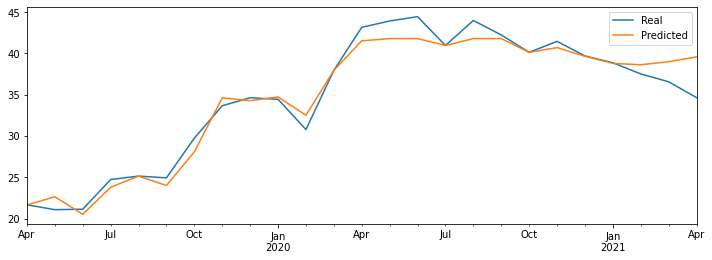

In [20]:
real = pd.concat([y_train, y_test]).values
predicted = np.concatenate([train_pred, val_pred])

unseen = np.zeros(len(real))
unseen[-len(predicted):] = 1

dates = df2.apply(lambda x: datetime(int(x.year), int(x.month), 1), axis=1)

occupation = pd.DataFrame({'Real': real, 'Predicted': predicted}, index=dates[3:])
occupation.plot(figsize=(12, 4));

### 7. Variable importance for the model

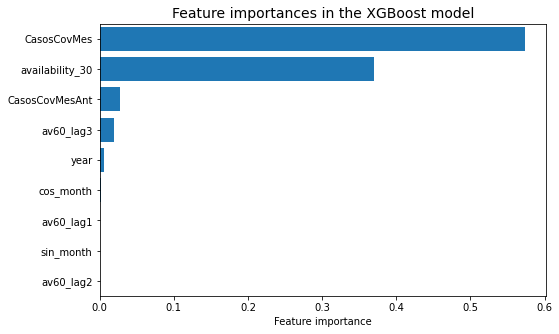

In [21]:
# Producing a dataframe of feature importances
features_weights = pd.DataFrame(xgb_model.feature_importances_, columns=['weight'], index=X_train.columns)
features_weights.sort_values('weight', inplace=True)

# Plotting feature importances
plt.figure(figsize=(8,5))
plt.barh(features_weights.index, features_weights.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

# Hyperparameter Tunning

Now that we have a result, we are going to improve the quality of the prediction by doing hyperparameter tuning. The optimizer we are using is based in Gaussian Processs Optimization and its library is available [here](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html).

This function execute the training process inside the optimizer. During our implementation, we have observed that even using seeds, our results still was changing. Due to that, we decided to train the model many times, one for each seed. Then, compute the average error of each seed. This result should be a better estimator of the final prediction error.

In [27]:
%%time

def run_xgb(params):
    
    max_depth, gamma, reg_alpha, reg_lambda, colsample_bytree, min_child_weight, n_estimators, learning_rate = params

    n_seeds = 10
    total_errors = np.zeros(n_seeds)

    for seed in range(n_seeds):
        
        np.random.seed(seed)

        xgb_model = xgb.XGBRegressor(        
            max_depth=max_depth, gamma=gamma, reg_alpha=reg_alpha, reg_lambda=reg_lambda,
            colsample_bytree=colsample_bytree, min_child_weight=min_child_weight,
            n_estimators=n_estimators, learning_rate=learning_rate, random_state=seed
        )

        xgb_model.fit(X_train, y_train)    
        pred = xgb_model.predict(X_val)

        error = mean_absolute_error(y_val, pred)    
        total_errors[seed] = error
        avg_seed_error = total_errors.mean()
    
    return avg_seed_error

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 13.6 µs


This is the hyperparameters intervals that will be passed to the optimizer.

In [42]:
space = [(10, 50),                        # max_depth
         (0.0, 0.5),                      # gamma
         (1, 5),                          # reg_alpha
         (1, 5),                          # reg_lambda
         (0.3, 1.0),                      # colsample_bytree
         (1, 10),                         # min_child_weight
         (50, 500),                       # n_estimetors
         (1e-3, 1e-1, 'log-uniform')]     # learning_rate

res = gp_minimize(run_xgb, space, random_state=0, n_calls=50)

In [43]:
max_depth, gamma, reg_alpha, reg_lambda, colsample_bytree, min_child_weight, n_estimators, learning_rate = res.x

### Retrain the model using the new hyperparameters

Now, we are going to retrain the model using the best hyperparameters selected by the optimizer, using all the dataset.

In [44]:
xgb_model = xgb.XGBRegressor(        
            max_depth=max_depth, gamma=gamma, reg_alpha=reg_alpha, reg_lambda=reg_lambda,
            colsample_bytree=colsample_bytree, min_child_weight=min_child_weight,
            n_estimators=n_estimators, learning_rate=learning_rate) 

X, Y = df.drop('availability_60', axis=1), df['availability_60']

xgb_model.fit(X, Y) 

train_pred = xgb_model.predict(X)

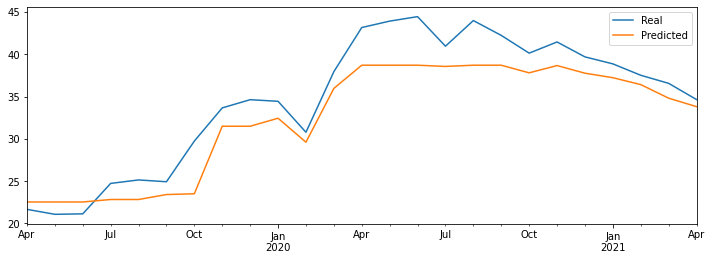

In [45]:
real = Y.values

unseen = np.zeros(len(real))
unseen[-len(predicted):] = 1

dates = df2.apply(lambda x: datetime(int(x.year), int(x.month), 1), axis=1)

occupation = pd.DataFrame({'Real': real, 'Predicted': train_pred}, index=dates[3:])
occupation.plot(figsize=(12, 4));

The obtained results for this model was not that good as that one obtained using RNN. It is necessary to change the set of hyperparameters in order to get a better prediction.

We will keep this notebook as a record of our work, but our main model is the RNN in Pytorch.